In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

import datetime
import matplotlib
from matplotlib import pyplot

In [3]:
import DataPrep
import error_evaluation

In [4]:
X_Above_test, X_Above_train, y_Above_test, y_Above_train, X_Near_test, X_Near_train, y_Near_test, y_Near_train, X_Below_test, X_Below_train, y_Below_test, y_Below_train = DataPrep.prep_day1_danger_train_test('../Data/V1.1FeaturesWithLabels30Days20131201To20180430.csv', ignore_extreme=True, oversample=False)

In [5]:
yColumns = ['o_Day1DangerNearTreeline']

In [6]:
gbmgpu = lgb.LGBMClassifier(objective=['auc'], device_type='gpu', learning_rate=.05)

In [7]:
%%time

gbmgpu.fit(X_Near_train.values, 
        y_Near_train[yColumns].values.ravel(), 
        eval_set=[(X_Near_test.values, y_Near_test[yColumns].values.ravel())],
        early_stopping_rounds=20,
        )

[1]	valid_0's multi_logloss: 1.35828
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 1.33328
[3]	valid_0's multi_logloss: 1.30984
[4]	valid_0's multi_logloss: 1.28909
[5]	valid_0's multi_logloss: 1.26853
[6]	valid_0's multi_logloss: 1.24963
[7]	valid_0's multi_logloss: 1.23239
[8]	valid_0's multi_logloss: 1.21622
[9]	valid_0's multi_logloss: 1.1996
[10]	valid_0's multi_logloss: 1.18467
[11]	valid_0's multi_logloss: 1.1706
[12]	valid_0's multi_logloss: 1.15756
[13]	valid_0's multi_logloss: 1.1454
[14]	valid_0's multi_logloss: 1.13404
[15]	valid_0's multi_logloss: 1.12244
[16]	valid_0's multi_logloss: 1.11219
[17]	valid_0's multi_logloss: 1.10178
[18]	valid_0's multi_logloss: 1.09162
[19]	valid_0's multi_logloss: 1.08231
[20]	valid_0's multi_logloss: 1.07314
[21]	valid_0's multi_logloss: 1.0648
[22]	valid_0's multi_logloss: 1.05675
[23]	valid_0's multi_logloss: 1.0492
[24]	valid_0's multi_logloss: 1.04205
[25]	valid_0's multi_logloss: 1.03534
[2

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        device_type='gpu', importance_type='split', learning_rate=0.05,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=['auc'], random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [ ]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'num_leaves': [15, 31, 63, 127, 255, 511, 1023, 2047, 4095]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="neg_log_loss", n_jobs=6, cv=kfold, verbose=10)

grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
%%time
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'bagging_fraction': [.5, .8],
    'num_leaves': [200, 350, 500],
    'feature_fraction': [.75, 1],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1],
    'class_weight': [None, 'balanced']
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="neg_log_loss", n_jobs=6, cv=kfold, verbose=10)

grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu', 
                            learning_rate=.01, num_class=4, num_leaves=500,
                            reg_alpha=0, reg_lambda=0, feature_fraction=.75,
                            bagging_fraction=.5, class_weight='balanced')

In [ ]:
%%time
gbmgpu.fit(X_Above_train.values, 
        y_Above_train[yColumns].values.ravel(), 
        eval_set=[(X_Above_test.values, y_Above_test[yColumns].values.ravel())],
        early_stopping_rounds=10
        )

In [ ]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu', 
                            learning_rate=.1, num_class=4, num_leaves=700,
                            feature_fraction=.75,
                            bagging_fraction=.3,                            
                            min_child_samples=80,  #prev best 40
                            n_estimators=500,
                            num_boost_round=1000)

In [ ]:
%%time
gbmgpu.fit(X_Near_train.values, 
        y_Near_train[yColumns].values.ravel(), 
        eval_set=[(X_Near_test.values, y_Near_test[yColumns].values.ravel())],
        early_stopping_rounds=20
        
        )

In [8]:
resultAbove = gbmgpu.predict(X_Near_test, gbmgpu.best_iteration_)

In [9]:
gbmgpu.classes_

array(['Considerable', 'High', 'Low', 'Moderate'], dtype=object)

In [10]:
resultAbove[:10]

array([[-1.89775717, -2.47869885,  2.56330368, -0.08524773],
       [-1.38940651, -2.52174978,  2.56537264, -0.4836233 ],
       [-1.15758997, -2.10433309,  1.76374894, -0.19146975],
       [-1.90976166, -2.53662657,  2.55239447, -0.13033717],
       [-1.40421505, -2.52174978,  2.53050125, -0.44750092],
       [-0.94704858, -2.10433309,  1.80153988, -0.13149905],
       [-1.84269546, -2.40253835,  2.52477613, -0.09140706],
       [-1.28338318, -2.52174978,  2.51218318, -0.39653116],
       [-0.96692268, -2.03281621,  1.40721609, -0.19150653],
       [-1.89765388, -2.53662657,  2.47550796, -0.11457399]])

In [11]:
best_preds = [np.argmax(line) for line in resultAbove]

In [12]:
best_preds_df = pd.DataFrame(best_preds, columns=['o_Day1DangerNearTreeline'])

In [13]:
best_preds_df.head()

,o_Day1DangerNearTreeline
0,2
1,2
2,2
3,2
4,2


In [14]:
mapping = {0:'Considerable', 1:'High', 2:'Low', 3:'Moderate'}
best_preds_df = best_preds_df.replace({'o_Day1DangerNearTreeline': mapping})
best_preds_df['o_Day1DangerNearTreeline'].head()

0    Low
1    Low
2    Low
3    Low
4    Low
Name: o_Day1DangerNearTreeline, dtype: object

Accuracy: 0.6314537749718931
Classification Report
              precision    recall  f1-score   support

Considerable       0.44      0.46      0.45     10768
        High       0.30      0.09      0.14      2805
         Low       0.85      0.69      0.76     12112
    Moderate       0.65      0.76      0.70     20567

   micro avg       0.63      0.63      0.63     46252
   macro avg       0.56      0.50      0.51     46252
weighted avg       0.63      0.63      0.62     46252

Normalized confusion matrix
Confusion matrix, without normalization


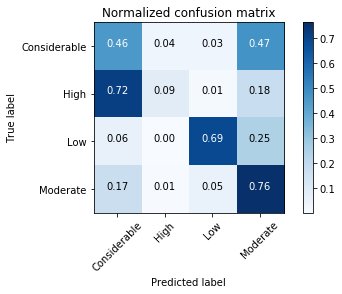

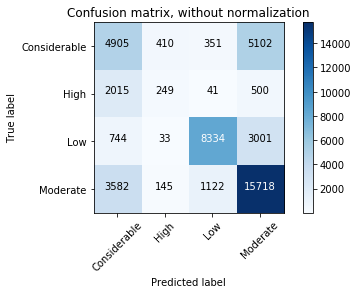

In [15]:
import matplotlib.pyplot as plt
error_evaluation.evaluateSingleClassShort(y_Near_test['o_Day1DangerNearTreeline'], best_preds_df)
cnf_matrix = confusion_matrix(y_Near_test['o_Day1DangerNearTreeline'], best_preds_df)
plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
%%time
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'bagging_fraction': [.2,.3,.4],
    'num_leaves': [600, 700, 800],
    'n_estimators': [500],
    'min_child_samples': [20, 60, 120],
    'min_child_weight': [.001, .01, .1],
    'feature_fraction': [.75]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="neg_log_loss", n_jobs=10, cv=kfold, verbose=10)

grid_result = grid_search.fit(X_Near_train.values, y_Near_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#above here

In [16]:
importances = pd.Series(gbmgpu.feature_importances_)
out = pd.concat([pd.Series(X_Near_train.columns), importances], axis=1)

In [17]:
out.columns = ['feature', 'importance']

In [19]:
out.sort_values('importance',ascending=False)[:10]

,feature,importance
863,DayOfYear,1192
52,n_f_APCPsurface,404
65,n_r_Prev1DayPrecip,213
73,n_r_SNOWDAS_SolidPrecip_kgpersquarem,124
507,n_r_Prev1DayPrecip20InPast,115
661,n_r_Prev1DayPrecip27InPast,109
66,n_f_Next24HourChangeInTempFromPrev3DayMax,108
862,c_IsContenentalSnowpack,97
89,n_r_Prev1DayPrecip1InPast,89
46,n_f_tempMaxF,88


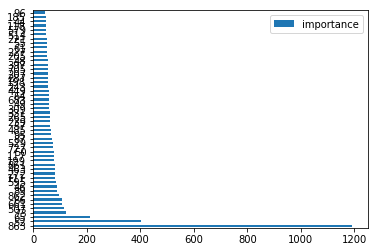

In [27]:
out[['feature', 'importance']].sort_values('importance',ascending=False)[:50].plot.barh()
plt.show()